# Tweet Sentiment Analysis
<span style="font-variant: small-caps; font-size: 2rem">~Nidhish Shah</span>

In [1]:
import pandas as pd
import spacy
import re
import seaborn as sns
import pickle
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

nlp = spacy.load('en_core_web_sm')

### Text Preprocessing

The hashtags regex `^#\S+|\s#\S+` matches any string that starts with `#` followed by one or more non-whitespace characters or any string that where a white space preceeds `#` which is followed by one or more non-whitespace characters.

Similarly the mentions regex `^@\S+|\s@\S+` matches any string starting with `@` followed by one or more non-white space characters.

The URL regex targets any strings that begin with `https://` or `http://` followed by one or more non-whitespace characters. The regex does not capture links that do not use the http/https protocol, however since majority of links shared online use the protocol, the regex should filter successfully most links.

We attempt to fix word lengthening often found in tweets such _hellloooo_ or _hiiiii_ by observing that words in English have usually at most two consecutive repeating characters. The regex captures any string with three or more consecutive characters and replaces with two repeating characters. This however doesn't fix the word _hiiiii_, which gets contracted to _hii_.

Finally we use the model provided by `spacy` to lemmatise the text and filter out all stopwords to reduce the number of words seen by the classifier.

In [2]:
hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"(https|http)?:\/\/\S+")
# Apostrophe kept to allow word contraction; eg = don't, can't
punctuation = re.compile(r"[^\w\s']") 

def preprocess_text(text):
    for pattern in [hashtags, mentions, urls, punctuation]:
        text = pattern.sub(' ', text)
    
    # Fix word lengthening. Most words in English have at most two consecutive repeating characters.
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)
    
    # Convert entire text to lower case and remove redundant whitespaces.
    cleaned_text = " ".join(text.lower().split())
    
    doc = nlp(cleaned_text)
    
    # Lemmatise words from original text that are not stopwords.
    preprocessed_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    
    return preprocessed_text

In [3]:
sample_text = [
    "Checkout my portfolio website: https://nidhishs.github.io",
    "I love running from city to city @runner #fun #health.",
    "Word contractions like 9 o'clock and ma'am should be preserved.",
    "Spelling mistakes like helllllooooo should get corrected. But thhhhis will not."
]

for text in sample_text:
    print(preprocess_text(text))

checkout portfolio website
love run city city
word contraction like 9 o'clock madam preserve
spelling mistake like helloo correct thhis


### Loading the Dataset, Count Vectorizer & Classifier Model.

We first try to load the dataset on which preprocessing has already been applied. If the preprocessed dataset is not found, we load the unprocessed dataset, apply the text preprocessing to each row and save it for retrieval later.

In [4]:
def load_dataset():
    try:
        df = pd.read_csv('sentiment_dataset_preproc.csv', encoding='utf-8')
    except FileNotFoundError:
        df = pd.read_csv('sentiment_dataset.csv', encoding='utf-8', nrows=100000)
        df.tweet = df.tweet.apply(preprocess_text)
        df.to_csv('sentiment_dataset_preproc.csv', index=False)
        
    return df

Similarly we load the Count Vectorizer to transform the text into vectorized data and the linear SVM classifier with stochastic gradient descent.

In [5]:
def load_count_vectorizer(data):
    try:
        count_vector = pickle.load(open('count_vector.pickle', 'rb'))
    except FileNotFoundError:
        count_vector = CountVectorizer(analyzer='word')
        count_vector.fit(data)
        pickle.dump(count_vector, open('count_vector.pickle', 'wb'))
    
    return count_vector

In [6]:
def load_sgdc(X, y):
    try:
        sgdc = pickle.load(open('sgdc.pickle', 'rb'))
    except FileNotFoundError:
        sgdc = SGDClassifier(random_state=5, max_iter=15, tol=None)
        sgdc.fit(X, y)
        pickle.dump(sgdc, open('sgdc.pickle', 'wb'))
    
    return sgdc

### Exploratory Data Analysis.

We split the preprocessed dataset into training and validation sets with a 90-10 split.

In [7]:
df_tweets = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(
        df_tweets.tweet.values,
        df_tweets.sentiment.values,
        test_size=0.1,
        random_state=0,
        stratify=df_tweets.sentiment.values,
        shuffle=True
    )

Note that the labels are already encoded with `1` as positive and `0` as negative.

In [8]:
df_tweets.head()
# 1 = Positive, 0 = Negative

,sentiment,tweet
0,1,papa johns deny debit card online order piggy
1,1,time choice push personal limit day rewire bra...
2,0,oh signal be home lol s funny wacko call u
3,1,not sorry pearson come round amp watch zach br...
4,0,tomorrow birthdayy be get old


Since both the classes have an equal number of samples, we do not need to do any further processing to balance them.

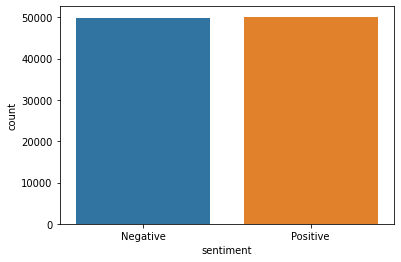

In [9]:
ax = sns.countplot(x="sentiment", data=df_tweets)
ax.set_xticklabels(['Negative', 'Positive']);

### Calculate the sentiment.

Each input text is preprocessed, converted to a vector and we use the LSVM model to predict the sentiment of the text.

In [10]:
def get_sentiment(texts, count_vector, sgdc):
    preproc_text = [preprocess_text(text) for text in texts]
    vector_text = count_vector.transform(preproc_text)
    predictions = sgdc.predict(vector_text)
    
    return predictions

In [11]:
count_vector = load_count_vectorizer(df_tweets.tweet)
X_train_count = count_vector.transform(X_train.astype('U'))
x_val_count = count_vector.transform(X_val.astype('U'))

We use the validation set to calculate the accuracy. The accuracy is lower than expected however this can be improved by using a recurrent neural network since language follows a sequence of words or a TF-IDF vectorizer where a keyword in a tweet can determine the entire sentiment of the text.

In [12]:
sgdc = load_sgdc(X_train_count, y_train)
y_predictions = sgdc.predict(x_val_count)
accuracy_score(y_predictions, y_val)

0.736

### Testing sample tweets.

In [13]:
sample_tweets = [
    "I'm looking forward to studying AI. Fun stories.",
    "I'm afraid of failing the test.",
    "I am absolutely disappointed by the fake news.",
    "Continue to be a good person."
]

In [14]:
sample_tweets_prediction = get_sentiment(sample_tweets, count_vector, sgdc)
for sentiment in sample_tweets_prediction:
    print('Positive' if sentiment==1 else 'Negative')

Positive
Negative
Negative
Positive


It is observed that all the predictions here are correct. This can be attributed to the fact that all the sentences are grammatically correct and have no spelling mistakes.